In [1]:
import re
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tqdm import tqdm
import spacy
import ast      
import seaborn as sns
from matplotlib import pyplot as plt
# Inline matplotlib (keep charts in this notebook)
%matplotlib inline 
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
import colorcet as cc
import numpy as np
import sqlite3 as sl
from database import db_constants, db_op
import warnings
warnings.filterwarnings('ignore')
import init
from wine_stat import freq, vis, common_stat
import statsmodels
from data_cleaning.text_filter import TextFilter
from pyecharts.charts import Map
from pyecharts import options as opts
import plotly.express as px

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mishar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Top Descriptive

In [2]:
# To generate data/adjectives_nouns. Takes 20-30 minutes to run

# stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
#     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
#     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 
#     'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
#     'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
#     'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
#     'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
#     'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
#     'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
#     't', 'can', 'will', 'just', 'don', 'should', 'now']

# def pre_process(sentence):
#     """
#     stopwords removal, punctuations removal, stemming/lemmentizing
#     """
    
#     #remove punctuations
#     pattern = re.compile(r'[^\w\s]')
#     sent_cleaned = pattern.sub('',str(sentence).lower())
    
#     #remove stopping words, such as of, is, and, I, am, ...
#     phrases_cleaned = ' '.join([i for i in sentence.split() if i not in stopwords])

#     #stemming (no need lemmentization)
#     lemmatizer = WordNetLemmatizer()
#     phrases_cleaned = [' '.join([lemmatizer.lemmatize(i) for i in s.split()]) for s in phrases_cleaned]
    
#     return sentence

# # Load English tokenizer, tagger, parser and NER
# nlp = spacy.load("en_core_web_sm")
# #spacy.prefer_gpu()

# tqdm.pandas()

# def get_adjectives(text, tag_ = 'JJ'):
#     blob = nlp(text)
#     return [ token.lemma_ for token in blob if token.tag_ == tag_]


# df = pd.read_csv('./data/winemag-data-130k-v2_cleaned.csv')
# df['description_cleaned'] = df['description'].progress_apply(lambda x: pre_process(x))
# df['description_adj_cleaned'] = df['description'].progress_apply(get_adjectives)
# df['description_noun_cleaned'] = df['description'].progress_apply(lambda x: get_adjectives(x, tag_ = 'NN'))
# df.to_csv('./data/adjectives_nouns.csv')

In [3]:
tqdm.pandas()

df = pd.read_csv('./data/adjectives_nouns.csv')
df['description_adj_cleaned'] = df['description_adj_cleaned'].apply(lambda x: ast.literal_eval(x))
df['description_noun_cleaned'] = df['description_noun_cleaned'].apply(lambda x: ast.literal_eval(x))

In [4]:
adjs = common_stat.counts_table(df, 'description_adj_cleaned',common_filter=20)

100%|██████████| 22276/22276 [00:00<00:00, 463566.62it/s]


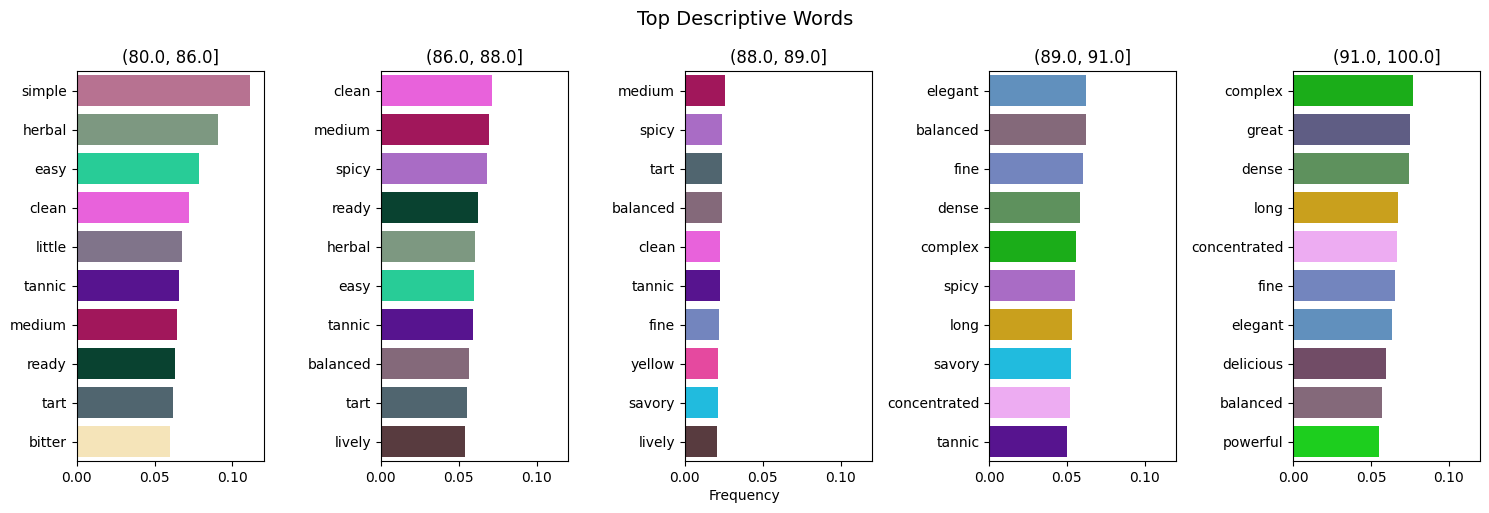

In [5]:
vis.draw_fig(df, adjs, title_ = 'Top Descriptive Words', save=True, topk=10, max_ = 0.12)

## Sunburst chart(Pie Chart)

In [7]:
# read in database
WINE_INIT_DB_NAME = db_constants.WINE_INIT_DB_NAME
WINE_INIT_PATH_TO_DB = 'database/' + WINE_INIT_DB_NAME
con = sl.connect(WINE_INIT_PATH_TO_DB)
sql_cmd = "SELECT * FROM wine_init"
df = pd.read_sql_query(sql_cmd, con, index_col = 'index')
con.close()

In [8]:
# wine_count under country -> province -> region
df_CnPR = df[['country', 'province','region_1']].value_counts()
df_CnPR = pd.DataFrame(df_CnPR).reset_index().rename(columns = {0 : 'wine_count'})

In [9]:
color = 'Bugn'
fig=px.sunburst(df_CnPR,path=['country','province','region_1'],values='wine_count',color='wine_count',color_continuous_scale=color)
fig.update_traces(textinfo='label + percent parent + value')

## Linear Regression of all price and point

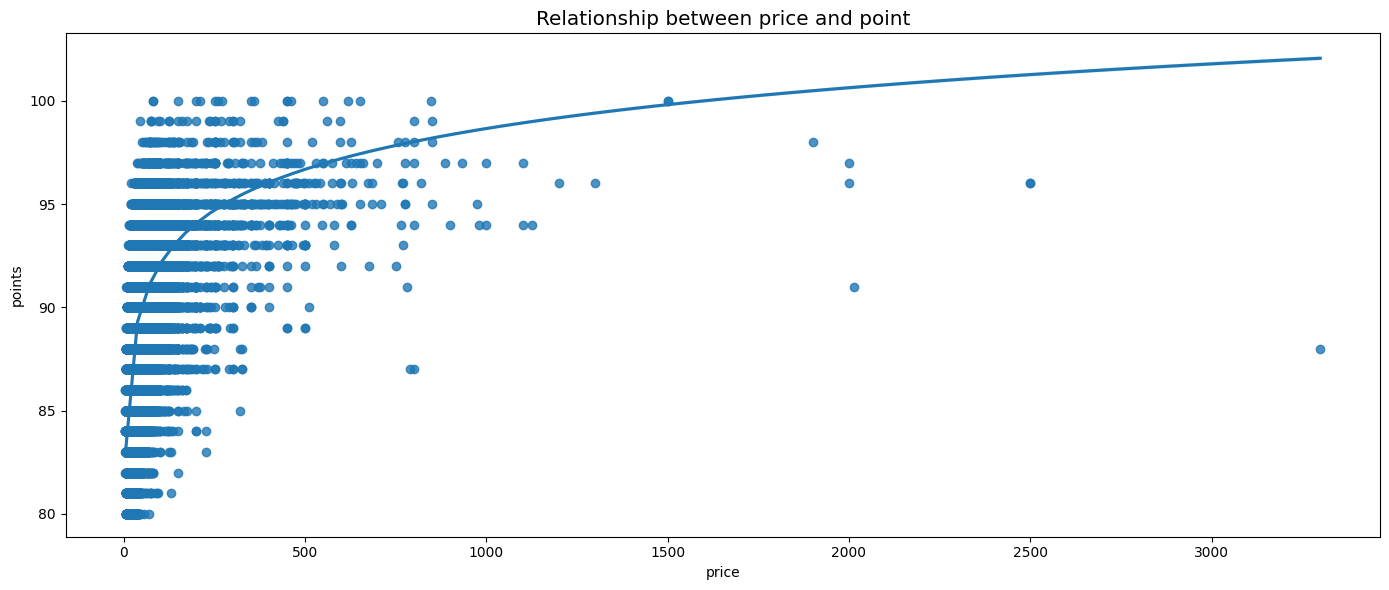

In [10]:
title = "Relationship between price and point"
plt.figure(figsize = [14,6])
ax = sns.regplot(x = df["price"], y="points", data=df, logx=True, truncate=True)
plt.title(title,fontsize='x-large')
plt.tight_layout()
# plt.savefig(f'./{title}.jpg',dpi=300)

## Hex grid (price & point groupby different columns)

In [11]:
# Limit price under 100
df_plimit = df[df['price']<=100]

<Figure size 1400x600 with 0 Axes>

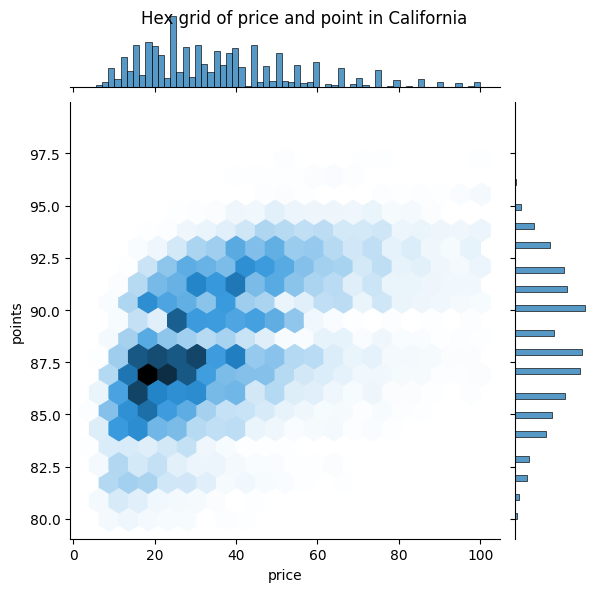

<Figure size 1400x600 with 0 Axes>

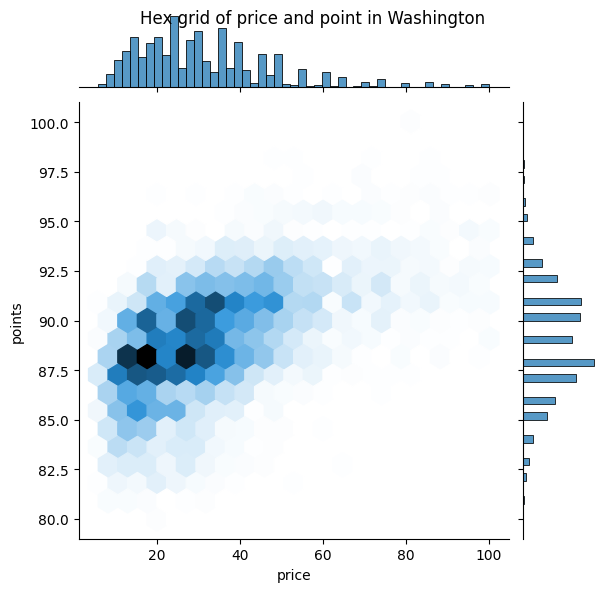

<Figure size 1400x600 with 0 Axes>

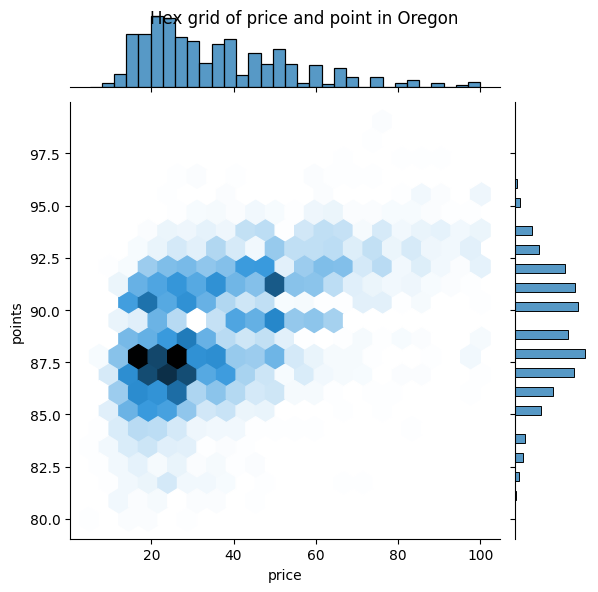

In [12]:
topProvince = df['province'].value_counts(normalize = True).head(3).index.tolist()
count = 1
for p in topProvince:
    title = f'Hex grid of price and point in {p}'
    plt.figure(figsize = [14,6])
    ax = sns.jointplot(x='price', y='points', data=df_plimit.loc[df_plimit['province'].isin([p])], kind='hex',gridsize=20)
    plt.suptitle(title)
#     plt.savefig(f'./0{count}-{title}.jpg',dpi=300)
    count += 1

<Figure size 1400x600 with 0 Axes>

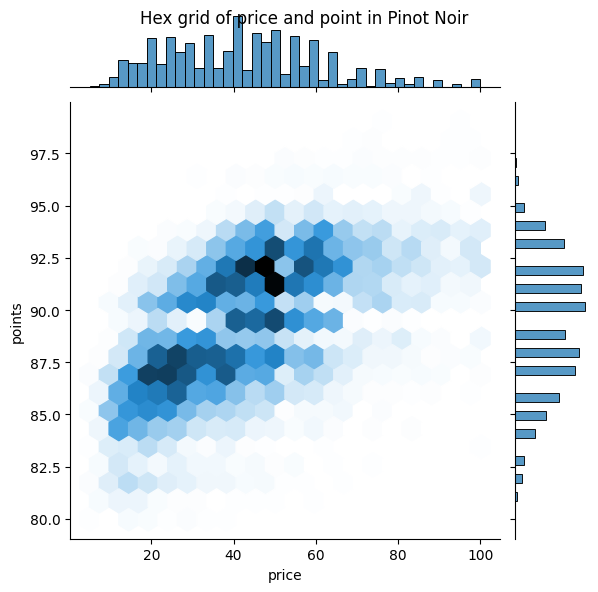

<Figure size 1400x600 with 0 Axes>

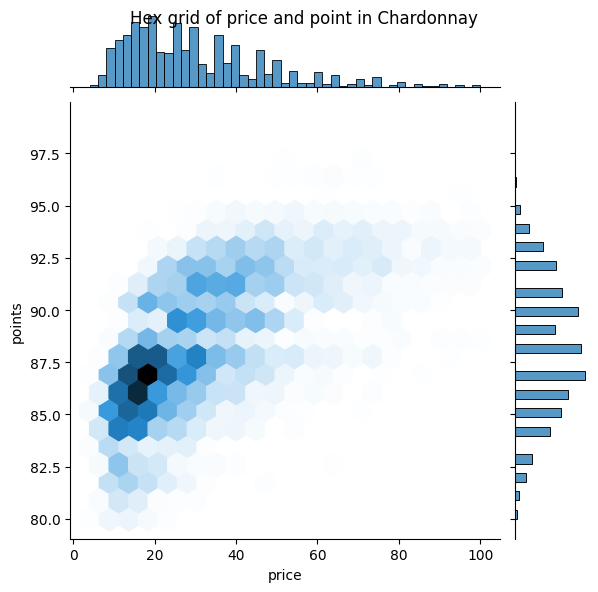

<Figure size 1400x600 with 0 Axes>

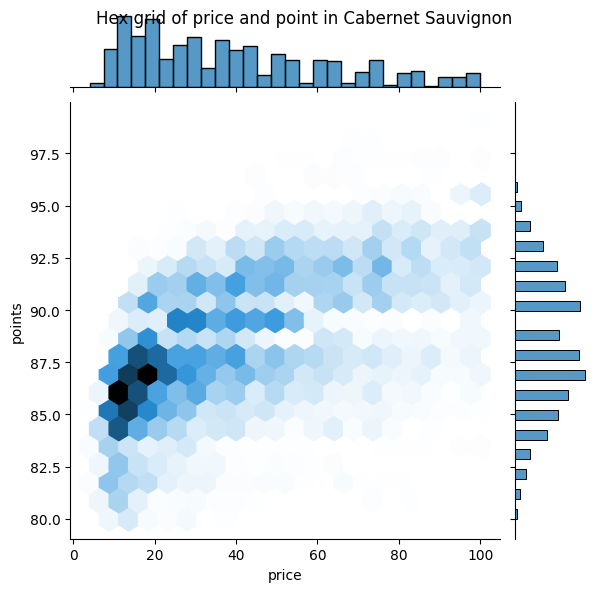

In [13]:
topVariety = df['variety'].value_counts(normalize = True).head(3).index.tolist()
count = 1
for v in topVariety:
    title = f'Hex grid of price and point in {v}'
    plt.figure(figsize = [14,6])
    ax = sns.jointplot(x='price', y='points', data=df_plimit.loc[df_plimit['variety'].isin([v])], kind='hex',gridsize=20)
    plt.suptitle(title)
#     plt.savefig(f'./0{count}-{title}.jpg',dpi=300)
    count += 1

# Wine Counts Map

In [14]:
df_map = df[df['price'] <= 1000]
df_map.replace("US","United States",inplace=True)
df_map.replace("England","United Kingdom",inplace=True)
df_map.replace("Czech Republic","Czech Rep.",inplace=True)
df_map.replace("Bosnia and Herzegovina","Bosnia and Herz.",inplace=True)
country=list(df_map['country'].value_counts().index)
counts=list(df_map['country'].value_counts().values)
a="'name'"
b="'value'"
data=[country,counts]
CountsPerCountry=[{eval(a):data[0][i],eval(b):data[1][i]} for i in range(len(country))]
print(CountsPerCountry)
#result:
#https://echarts.apache.org/examples/en/editor.html?c=map-usa&code=LYTwwgFghgTgLgOgM4QPYHcAyqoBMCWAdgOYAUAlANwBQAJAsQKZykBKA8uwCoD6ACgEEuACQAEAalEByAPS4ocKDKhIkzGU1Qz0qGABtcCAFZJUhKQBpRAMwCuhAMZx8Z0aVtIoAKVOFyogG9qUVFQSFhECHxcRmw8IjIqYNFGB2h4JAQYRmJ8JDhGGABZKAAHUikAVQBlAUtRD29fKyCQkIE9FQBrKAAuQOS20T1Gazh-gFoARgBmKYtBtrhUUv6AJgBWBaGQ9Gi4CH6pjcWAX2224Sh0KHx8ftadkbHJqamABguh5dXRNYAOL5tPa4A79E5Dc6LKR8WyFZaiVj4ByoKQPRYhZ7jUQTADsADYgSEfutCRjRCCwX8zslTkkQitnK4ALwDb74OAjdE7UQFAAe2KkAHUiIxEYwAG74RjoURgVD2OBIURC3QGEGMSzkrH9KQwfDECBwKRnIHLVB6Zy_R7ffXEJgwXUcxjALU8lAYAAijE6IH6n3JcBgUEISA5LkIntswaZhH9CDWpsWUqQtigehK1u1o0FdqNbp2wCIRyJoSgfPBABY1vjK6WiKwQ0xuTzRCi9Lp-gBtclDKQAYjmM3xAE4NgXW9J-5WNriNgAjSsT1sD3GVvC4KbLnkDqDz3Ajxgj7c7AeMd7WGbWf4nvv96wP6zz6y3toD6yMc8j96vkLv-SMPiW6lne1iVviuCVjMv5TrguIzO8ay4jBu4bO8iH4iak4ALrklCPL8tiXZSMIBoQPUUjYOgUjYaWDjpg4tidPOXK8jAcJJt8qAWvOqAVmyOweug_RBnCpYyDIujSoQgoSvCyLpieOrSFiJ4ktIPwnh-CjRowLY8vIigAGrSsJgSiNkeDsIQeh-jY6ZqKI-Gttk-S6HpgTOe6UByQISAAJLAFAzaeXhnFtGo-qMEg3bkjaOyEFAwAecKorilKMpygqMlIK-cAgKUKVBaUr4wDgwAiexjAgWWvxVLUr4uqU0BhjFAmTsxPr6ZOohCZVHE9U5vZOTVhl9KIXYBFIiXJWi0iVIQzq4KI1SKAUuVWFIErpnCc0bNWtbnIE01JZquoAGLBo4mqbdtei7UcuIEpWR1TTNZ3SP5ii2RRd0PaIUyjlML0tCds26tUpS3OYt07R9-KzjMr1gx9MK6HAtjEIpsP3R9lb_HOyPvXNUiQPgIy_XDc2VpWgNE6dJMCDATAyUQUCU7jc0zHO-L0-D0gCB4Qb4OzOP_UhI7_HzqOC_kwZ6CLHPi2sI4g8dxO6gA4oUQWECASsfWsUxrO80skwAcplABajDpiGuAG3Nsy4lLoMa9I1QKgcogCNY-r0Y7Rwq0jbsM7q_lIMGPqB6I-MjmbWvZKkN3SH9eNAQn0hgCGeCi6nVPrPtmckfYWMwPrYsfcDGzFwAQkxZeK5XTu08XrCoLrTf55zQem6H_NVOxxBphX3f_R88f96jXDRl0jCj1tBeiN-xfa7ouR54vPeiP8atvWHHsdnJi2b2nc3_H36sH6TZUKF3W__biUzF0UjB8siqLN_0uKX_vA8LUtUQABpBIuAO4x1HC_C0YDtoxw2JPK-A9a7BgAF7kxjpWXExdMCMHnCGMwMcZg1yniTIouhUAOBRDHAExc-CFFsDHOmJDdSVC6MGUUjC94oxJtUQo8575nyDsXMAKDUgQHFKUBAjC1gvygA4RgYCT7SOEQVdiG0x5V2fswz6hACCnyXggv-qNqh7DgKI_Q9sY5YO0ZRWwfIXS8WjMQCBddUBIBPqIe2ohhCFBQVIr-fxi5M2SkogJMibHVCPlALoAil5aMQajMmiVGGnFwjyU4iw0lORoCEMI6REBqDgOwUosZSCMgjEkOklAgA


[{'name': 'United States', 'value': 54264}, {'name': 'France', 'value': 17764}, {'name': 'Italy', 'value': 16914}, {'name': 'Spain', 'value': 6573}, {'name': 'Portugal', 'value': 4875}, {'name': 'Chile', 'value': 4415}, {'name': 'Argentina', 'value': 3756}, {'name': 'Austria', 'value': 2798}, {'name': 'Australia', 'value': 2294}, {'name': 'Germany', 'value': 2120}, {'name': 'New Zealand', 'value': 1378}, {'name': 'South Africa', 'value': 1293}, {'name': 'Israel', 'value': 489}, {'name': 'Greece', 'value': 461}, {'name': 'Canada', 'value': 254}, {'name': 'Hungary', 'value': 145}, {'name': 'Bulgaria', 'value': 141}, {'name': 'Romania', 'value': 120}, {'name': 'Uruguay', 'value': 109}, {'name': 'Turkey', 'value': 90}, {'name': 'Georgia', 'value': 84}, {'name': 'Slovenia', 'value': 80}, {'name': 'Croatia', 'value': 71}, {'name': 'Mexico', 'value': 70}, {'name': 'United Kingdom', 'value': 69}, {'name': 'Moldova', 'value': 59}, {'name': 'Brazil', 'value': 47}, {'name': 'Lebanon', 'value': 35

# Correlation between Points and Mean Description Length and Mean Price

In [15]:
df_points=df[df['price'] <= 1000]
df_points['description_length']=df_points['description'].str.len()
desciprtion=pd.DataFrame(df_points,columns=['description_length','points'])
#sns.lmplot(data=desciprtion,x="description_length",y="points")
df_PointsMeanLength = df_points.groupby("points").agg({'description_length':'mean'}).sort_values(by = 'description_length',ascending = False)
df_PointsMeanLength=df_PointsMeanLength.reset_index()
df_PointsMeanPrice=df_taster.groupby("points").agg({'price':'mean'}).sort_values(by = 'price',ascending = False)
df_PointsMeanPrice=df_PointsMeanPrice.reset_index()
df_taster=df_top5Taster[df_top5Taster["taster_name"]==taster]
sns.set_theme(style="darkgrid")
g=sns.lmplot(data=df_PointsMeanLength,x="description_length",y="points",scatter_kws={"s": 50, "alpha": .5})
g.set(xlim=(100,450))
title_="Correlation between Points and Mean Description Length"
plt.title(title_,fontsize='x-large')
#plt.savefig(f'./{title_}.jpg',dpi=300)
df_top5Taster = df_points[df_points["taster_name"].str.contains("Roger Voss|Michael Schachner|Kerin O’Keefe|Virginie Boone|Paul Gregutt")==True]
for taster in ["Roger Voss","Michael Schachner","Kerin O’Keefe","Virginie Boone","Paul Gregutt"]:
    g=sns.lmplot(data=df_PointsMeanLength,x="description_length",y="points",scatter_kws={"s": 50, "alpha": .5},logx=True)
    g.set(xlim=(100,450))
    title_="Mean Description Length Given Points - "+taster
    plt.title(title_,fontsize='x-large')
    #plt.savefig(f'./{title_}.jpg',dpi=300,bbox_inches='tight')
    g=sns.lmplot(data=df_PointsMeanPrice,x="price",y="points",scatter_kws={"s": 50, "alpha": .5,"color":"m"},line_kws={"linewidth": 3, "alpha": .5,"color":"m"},logx=True)
    g.set(xlim=(0,600))
    title_="Mean Price Given Points - "+taster
    plt.title(title_,fontsize='x-large')
    #plt.savefig(f'./{title_}.jpg',dpi=300,bbox_inches='tight')

NameError: name 'df_taster' is not defined

# Points/Cost Ratio Analysis

In [ ]:
df = pd.read_csv('./data/winemag-data-130k-v2_cleaned.csv')

In [ ]:
points_norm = (df['points'] - 80)/(100-80)*100
df['points_norm'] = points_norm
point_price_ratio = df['points_norm']/df['price']
df['point_price_ratio'] = point_price_ratio

df_countryMeanPrice = df.groupby("country").agg({'price':'mean'}).sort_values(by = 'price',ascending = False)
df_countryMeanPrice = df_countryMeanPrice.reset_index()

df_countryMeanPoints = df.groupby("country").agg({'point_price_ratio':'mean'}).sort_values(by = 'point_price_ratio',ascending = False)
df_countryMeanPoints = df_countryMeanPoints.reset_index()

df_meanPricePoints = df_countryMeanPoints.merge(df_countryMeanPrice)
plt.figure(figsize = [20,8])
barWidth = 0.4

r1 = np.arange(len(df_meanPricePoints['country']))
r2 = [x + barWidth for x in r1]

plt.bar(r1, df_meanPricePoints['price']/100, color='#ADFF2F', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, df_meanPricePoints['point_price_ratio'], color='#87CEFA', width=barWidth, edgecolor='white', label='var2')


# Add xticks on the middle of the group bars
plt.xlabel('country', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(df_meanPricePoints['country']))], df_meanPricePoints['country'],rotation = 75)
 
# Create legend & Show graphic
plt.legend(('price/100','point_price_ratio'))
plt.show()

In [ ]:
sns.lmplot(x="price",
           y= "point_price_ratio",
           data=df,
           fit_reg=False
           ).set(title='Wine Cost/Taset Ratio')

In [ ]:
df_taste_province = df.groupby(['province']).agg({'point_price_ratio':'mean','province':'count'}).sort_values(by = 'point_price_ratio',ascending = False)
df_taste_province[df_taste_province['province']>=4500]

In [ ]:
for province in ['Washington','Bordeaux','Oregon','California','Tuscany']:
    sns.lmplot(x="price",
           y= "point_price_ratio",
           data=df[df['province']==province],
           fit_reg=False
           ).set(title=province)

## Initialize Database and Print Null Info After Null Cleaning

In [ ]:
#setup database
cur, con = init.init()

#print summary info of table
wine_init_table = db_op.read_table(cur, con, db_constants.WINE_INIT_TABLE_NAME)
print(wine_init_table.columns)
print(wine_init_table)

## Plot Frequency Pie Charts

In [ ]:
#initialize frequency tables
init.set_freq_tables(testing=False)
init.get_top_ns_tables(cur=cur, con=con)
vis.plot_pie_charts_all_top_n_freq_tables(cur, con, freq.glbl_top_n_freq_schemas)

## Get Basic Stats (Count, Avg, Median) and Their Plots

In [ ]:
# get basic stats of price (produces corresponding tables)
factors_to_group_by = ['country', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'variety', 'winery']
for factor in factors_to_group_by:
  #  - single level grouping for price 
  common_stat.get_basic_stats_of_col1_grouped_by_cols(cur, con, 'price', [factor])

# get basic stats of points (produces corresponding tables)
for factor in factors_to_group_by:
  #  - single level grouping for price 
  common_stat.get_basic_stats_of_col1_grouped_by_cols(cur, con, 'points', [factor])

In [ ]:
# - plotting for single level grouping for price
#  - mean price:
for factor in factors_to_group_by:
  p_title = f'Average Price of Wine By {factor[0].upper() + factor[1:] }'
  y_axis_desc = 'Mean price in $'
  color = (0.8, 0.8, 0.8, 0.1) if factor != 'country' else None #plot separate palette of colors for countries
  vis.plot_bar_chart(
    cur,
    con,
    f'price_basic_stats_grouped_by_{factor}',
    factor,
    'mean',
    limit=40,
    y_axis_description=y_axis_desc,
    p_title=p_title,
    color=color,
    edgecolor='blue',
    orient='h',
    figsize=[8,10]
  )
# - median price:
for factor in factors_to_group_by:
  p_title = f'Median Price of Wine By {factor[0].upper() + factor[1:] }'
  y_axis_desc = 'Median price in $'
  color = (0.8, 0.8, 0.8, 0.1) if factor != 'country' else None #plot separate palette of colors for countries
  vis.plot_bar_chart(
    cur,
    con,
    f'price_basic_stats_grouped_by_{factor}',
    factor,
    'median',
    limit=40,
    y_axis_description=y_axis_desc,
    p_title=p_title,
    color=color,
    edgecolor='blue',
    orient='h',
    figsize=[8,10]
  )
# average points
for factor in factors_to_group_by:
  p_title = f'Average Points of Wine By {factor[0].upper() + factor[1:] }'
  y_axis_desc = 'Mean points (1-100)'
  color = (0.8, 0.8, 0.8, 0.1) if factor != 'country' else None #plot separate palette of colors for countries
  vis.plot_bar_chart(
    cur,
    con,
    f'points_basic_stats_grouped_by_{factor}',
    factor,
    'mean',
    limit=40,
    y_axis_description=y_axis_desc,
    p_title=p_title,
    color=color,
    edgecolor='blue',
    orient='h',
    figsize=[8,10],
    bar_limits=(78, 100)
  )
# median points
for factor in factors_to_group_by:
  p_title = f'Median Points of Wine By {factor[0].upper() + factor[1:] }'
  y_axis_desc = 'Median points (1-100)'
  color = (0.8, 0.8, 0.8, 0.1) if factor != 'country' else None #plot separate palette of colors for countries
  vis.plot_bar_chart(
    cur,
    con,
    f'points_basic_stats_grouped_by_{factor}',
    factor,
    'median',
    limit=40,
    y_axis_description=y_axis_desc,
    p_title=p_title,
    color=color,
    edgecolor='blue',
    orient='h',
    figsize=[8,10],
    bar_limits=(78,100)
  )
# - counts of single grouped by
for factor in factors_to_group_by:
  p_title = f'Count By {factor[0].upper() + factor[1:] }'
  y_axis_desc = 'Number of Distinct Occurrences in Dataset'
  color = (0.8, 0.8, 0.8, 0.1) if factor != 'country' else None #plot separate palette of colors for countries
  vis.plot_bar_chart(
    cur,
    con,
    f'price_basic_stats_grouped_by_{factor}',
    factor,
    'count',
    limit=40,
    y_axis_description=y_axis_desc,
    p_title=p_title,
    color=color,
    edgecolor='blue',
    orient='h',
    figsize=[8.9,10],
    label_bars=True
  )


## Get Overall Table From Database

In [ ]:
wine_table = pd.read_sql(f'SELECT * FROM {db_constants.WINE_INIT_TABLE_NAME}', con)

## Count Tasters and Countries

In [ ]:
# count number of times India appears
country_counts = wine_table.groupby('country')['country'].count()
print(country_counts)

In [ ]:
tasters_by_country = wine_table.groupby(by=['country', 'taster_name'], group_keys=False)['country', 'taster_name'].size().reset_index(name='count')
tasters_for_india = tasters_by_country[tasters_by_country['country'] == 'India']
print(tasters_for_india)
print(tasters_by_country[tasters_by_country['taster_name'] == 'Mike DeSimone'])

In [ ]:
tasters_by_country = tasters_by_country.sort_values('count', ascending=False)
tasters_by_country.to_sql('tasters_by_country', con, if_exists='replace')
tasters_by_country_limited_table_name = common_stat.get_table_recurs_limit_grouped_by(cur, con, 'tasters_by_country', col_of_scores='count', cols_to_group_by=['country', 'taster_name'], col_limits=[40, 10000], keep_duplicates=[True, True])
tasters_by_country_limited = db_op.read_table(cur, con, tasters_by_country_limited_table_name)
tasters_by_country_limited = tasters_by_country_limited.drop(columns=['index'])
print(tasters_by_country_limited)

In [ ]:
#num unique info
print("************")
print("Number of unique entries for various factors: ")
for factor in factors_to_group_by:
  print(f"The number of unique {factor}s that we have (by counting) is: ", common_stat.get_num_unique_rows_in_column(cur, con, db_constants.WINE_INIT_TABLE_NAME, factor))

## Plot Heatmaps for Tasters to Countries

In [ ]:
#plot heatmaps for taster_names
# by counts
fig, ax = plt.subplots(figsize=(10,10))
tasters_by_country_limited_for_heatmap = tasters_by_country_limited.pivot('country', 'taster_name', 'count')
heatmap_counts = sns.heatmap(tasters_by_country_limited_for_heatmap, 
  ax=ax, norm=LogNorm(vmin=1, vmax=14395)) 
plt.title("Heatmap of Review Counts to Countries")
sns.set(rc={'figure.facecolor':'lightgrey'})
#sns.set(rc={'axes.facecolor':'lightgrey'})

In [ ]:
# plot taster name median number of points
fig, ax = plt.subplots(figsize=(10,10))
taster_name_country_points_median_table_name = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['country', 'taster_name']
)
taster_name_country_points_median_orig = db_op.read_table(cur, con, taster_name_country_points_median_table_name).sort_values('mean', ascending=False)
taster_name_country_points_median = taster_name_country_points_median_orig[['country', 'taster_name', 'mean']]
taster_name_country_points_median = taster_name_country_points_median.reset_index().drop(columns=['index']) #.pivot('country', 'taster_name', 'median')
taster_name_country_points_median_for_heatmap = taster_name_country_points_median.pivot('country', 'taster_name', 'mean')
heatmap_taster_country_points_median = sns.heatmap(taster_name_country_points_median_for_heatmap, 
ax=ax, norm=LogNorm(vmin=82.0, vmax=93.0)) 
plt.title("Heatmap of Review Mean Points to Countries.")
plt.xlabel("Taster name")
plt.ylabel("Country reviewed")

## Plot Distributions Grouped by Variables (like Country, Reviewer, Province)

         country         taster_name       mean
0      Australia   Christina Pickard  93.000000
1        England    Anne Krebiehl MW  91.550725
2       Bulgaria       Mike DeSimone  91.000000
3        Austria    Anne Krebiehl MW  90.681122
4         France    Anne Krebiehl MW  90.466176
..           ...                 ...        ...
104         Peru   Michael Schachner  83.562500
105      Ukraine  Anna Lee C. Iijima  83.500000
106  Switzerland     Susan Kostrzewa  83.000000
107        Spain       Lauren Buzzeo  83.000000
108       France   Michael Schachner  82.850000

[109 rows x 3 columns]


Text(0.5, 12.44444444444443, 'Average points assigned')

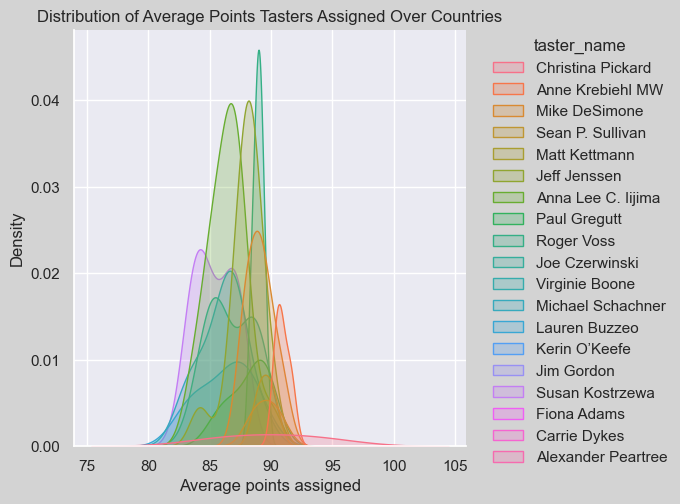

In [ ]:
#plot distributions of average points by reviewer
print(taster_name_country_points_median)
taster_name_dists_plot = sns.displot(taster_name_country_points_median, x='mean', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Average Points Tasters Assigned Over Countries")
plt.xlabel("Average points assigned")

In [ ]:
#plot distributions of average points by reviewer
taster_names_all = set(taster_name_country_points_median['taster_name'].unique())
taster_names_all = set({ #from just-above
  'Jim Gordon', 
  "Kerin O’Keefe", 
  'Roger Voss', 
  'Virginie Boone', 
  'Alexander Peartree', 
  'Mike DeSimone', 
  'Jeff Jenssen', 
  'Fiona Adams', 
  'Anne Krebiehl\xa0MW', 
  'Sean P. Sullivan', 
  'Christina Pickard', 
  'Matt Kettmann', 
  'Joe Czerwinski', 
  'Michael Schachner', 
  'Lauren Buzzeo', 
  'Carrie Dykes', 
  'Anna Lee C. Iijima', 
  'Susan Kostrzewa', 
  'Paul Gregutt'
})  
taster_name_dists_plot = sns.displot(taster_name_country_points_median[taster_name_country_points_median['taster_name'].isin(taster_names_all)]
, x='mean', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Average Points Tasters Assigned Over Countries")
plt.xlabel("Average points assigned")

In [ ]:
# get standard distributions of means by taster_name-country for each taster_name
to_save_table_name_taster_name_country_points_mean_orig = 'taster_name_country_points_mean_orig'
taster_name_country_points_median_orig.to_sql(to_save_table_name_taster_name_country_points_mean_orig, con, if_exists='replace')
taster_std_table_name = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, 'median', cols_to_group_by=['taster_name'],
  input_table_name = to_save_table_name_taster_name_country_points_mean_orig,
  res_table_suffix="",
  stats_to_compute=['std']
)
taster_std = db_op.read_table(cur, con, taster_std_table_name)
print(taster_std)

In [ ]:
#drop reviewers that reviewed in only one country (ie NaN std above) from analysis here
taster_std = taster_std.dropna()

#plot where tasters have std less than:
std_to_split_tasters_on = 1.6
taster_std_set_tasters_std_less = set(taster_std[taster_std['std'] <= std_to_split_tasters_on]['taster_name'].unique())
taster_std_set_tasters_std_greater = set(taster_std[taster_std['std'] > std_to_split_tasters_on]['taster_name'].unique())

#plot for tasters-countries where std is less than or equal to std to split on:
taster_name_dists_plot = sns.displot(taster_name_country_points_median[taster_name_country_points_median['taster_name'].isin(taster_std_set_tasters_std_less)]
, x='mean', hue='taster_name', kind='kde', fill=True) #, ax=ax)
plt.title("Distribution of Average Points Tasters Assigned Over Countries", y=1.08)
plt.xlabel("Average points assigned over countries")
plt.xlim(77, 102)
plt.ylim(0, 0.14)

#plot for tasters-countries where std is greater than std to split on:
taster_name_dists_plot = sns.displot(taster_name_country_points_median[taster_name_country_points_median['taster_name'].isin(taster_std_set_tasters_std_greater)]
, x='mean', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Average Points Tasters Assigned Over Countries", y=1.08)
plt.xlabel("Average points assigned over countries")
plt.xlim(77, 102)
plt.ylim(0, 0.14)





In [ ]:
#scatter plot of number of times reviewed to average points given, and also for country, and country-province, and country-province-region_1,
#and grouped by 
table_name_taster_name_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['taster_name']
)
table_name_taster_name__country_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['country', 'taster_name']
)
table_name_taster_name_country_province_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['country', 'province', 'taster_name']
)
table_name_taster_name_country_province_region1_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['country', 'province', 'region_1', 'taster_name']
)
table_name_taster_name_variety_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['variety', 'taster_name']
)
table_name_taster_name_winery_points_mean_count_orig = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, col_name='points', cols_to_group_by=['winery', 'taster_name']
)

table_taster_name_points_mean_count = db_op.read_table(cur, con, table_name_taster_name_points_mean_count_orig)[['taster_name', 'count', 'mean']]
table_taster_name_country_points_mean_count = db_op.read_table(cur, con, table_name_taster_name__country_points_mean_count_orig)[['country', 'taster_name', 'count', 'mean']]
table_taster_name_country_province_points_mean_count = db_op.read_table(cur, con, table_name_taster_name_country_province_points_mean_count_orig)[['country', 'province', 'taster_name', 'count', 'mean']]
table_taster_name_country_province_region1_points_mean_count = db_op.read_table(cur, con, table_name_taster_name_country_province_region1_points_mean_count_orig)[['country', 'province', 'region_1', 'taster_name', 'count', 'mean']]
table_taster_name_variety_points_mean_count = db_op.read_table(cur, con, table_name_taster_name_variety_points_mean_count_orig)[['variety', 'taster_name', 'count', 'mean']]
table_taster_name_winery_points_mean_count = db_op.read_table(cur, con, table_name_taster_name_winery_points_mean_count_orig)[['winery', 'taster_name', 'count', 'mean']]


#plot for taster_names overall
figure(figsize=(10,10))
#sns.scatterplot(data=table_taster_name_points_mean_count, x='mean', y='count', hue='taster_name')
sns.lmplot(x="mean", y="count", data=table_taster_name_points_mean_count,
           robust=True, ci=None, scatter_kws={"s": 80})
plt.title("Average Points vs Number Reviews for Tasters")

#plot for taster_names to countries
figure(figsize=(10,10))
sns.lmplot(x="mean", y="count", data=table_taster_name_country_points_mean_count,
           robust=True)
plt.title("Average Points vs Number Reviews for Tasters for Each Country")

#plot for taster_names to countries and provinces
figure(figsize=(10,10))
sns.lmplot(x="mean", y="count", data=table_taster_name_country_province_points_mean_count,
           robust=True)
plt.title("Average Points vs Number Reviews for Tasters for Each Country-Province Combination")

#plot for taster_names to countries and provinces and regions
figure(figsize=(10,10))
sns.lmplot(x="mean", y="count", data=table_taster_name_country_province_region1_points_mean_count,
           robust=True)
plt.title("Average Points vs Number Reviews for Tasters for Each Country-Province-Region1 Combination")

#plot for taster_names to variety
sns.lmplot(x="mean", y="count", data=table_taster_name_variety_points_mean_count,
           robust=True, ci=None, scatter_kws={"s": 80})
plt.title("Average Points vs Number Reviews for Tasters Per Wine Varieties")

#plot for taster_names to winery
sns.lmplot(x="mean", y="count", data=table_taster_name_winery_points_mean_count,
           robust=True, ci=None, scatter_kws={"s": 80})
plt.title("Average Points vs Number Reviews for Tasters per Wineries")

In [ ]:
#plot distributions of points assigned for each taster
taster_name_points_table_name = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, 'points', cols_to_group_by=['taster_name']
)
taster_name_points_no_stats_table_name = db_op.read_table(cur, con, db_constants.WINE_INIT_TABLE_NAME)[['points', 'taster_name']]
tester_name_points = db_op.read_table(cur, con, taster_name_points_table_name)
taster_std = tester_name_points[['taster_name', 'std']]
print(taster_std)
print(tester_name_points)

#drop reviews that only reviewed once
taster_std = taster_std.dropna()

#plot where tasters have std less than:
std_to_split_tasters_on = 2.8
taster_std_set_tasters_std_less = set(taster_std[taster_std['std'] <= std_to_split_tasters_on]['taster_name'].unique())
taster_std_set_tasters_std_greater = set(taster_std[taster_std['std'] > std_to_split_tasters_on]['taster_name'].unique())
tasters_points_std_less = taster_name_points_no_stats_table_name[taster_name_points_no_stats_table_name['taster_name'].isin(taster_std_set_tasters_std_less)][['points', 'taster_name']]
tasters_points_std_greater = taster_name_points_no_stats_table_name[taster_name_points_no_stats_table_name['taster_name'].isin(taster_std_set_tasters_std_greater)][['points', 'taster_name']]

#plot for tasters-countries where std is less than or equal to std to split on:
taster_name_dists_plot = sns.displot(tasters_points_std_less
, x='points', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Points Tasters Assigned")
plt.xlabel("Points assigned by reviewer")

#plot for tasters-countries where std is greater than std to split on:
taster_name_dists_plot = sns.displot(tasters_points_std_greater
, x='points', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Points Tasters Assigned")
plt.xlabel("Points assigned by reviewer")

In [ ]:
# (using from above): plotting points grouped by winery, variety
# - plot distributions of points assigned for each taster by variety
taster_name_points_table_name = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, 'points', cols_to_group_by=['taster_name', 'variety']
)
# taster_name_points_no_stats_table_name = db_op.read_table(cur, con, db_constants.WINE_INIT_TABLE_NAME).groupby(['points', 'taster_name'])[['points', 'taster_name', 'variety']].apply(lambda x: x)
tester_name_points = db_op.read_table(cur, con, taster_name_points_table_name)

#plot for tasters-countries where std is less than or equal to std to split on:
taster_name_dists_plot = sns.displot(tester_name_points[['mean', 'taster_name']]
, x='mean', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Average Points Tasters For Wine Varieties Assigned")
plt.xlabel("Average points assigned by reviewer by wine variety")
plt.ylim(0, 0.035)

# - plot distributions of points assigned for each taster by winery
taster_name_points_table_name = common_stat.get_basic_stats_of_col1_grouped_by_cols(
  cur, con, 'points', cols_to_group_by=['taster_name', 'winery']
)
# taster_name_points_no_stats_table_name = db_op.read_table(cur, con, db_constants.WINE_INIT_TABLE_NAME).groupby(['points', 'taster_name'])[['points', 'taster_name', 'variety']].apply(lambda x: x)
tester_name_points = db_op.read_table(cur, con, taster_name_points_table_name)

#plot for tasters-countries where std is less than or equal to std to split on:
taster_name_dists_plot = sns.displot(tester_name_points[['mean', 'taster_name']]
, x='mean', hue='taster_name', kind='kde', fill=True)
plt.title("Distribution of Average Points Tasters Assigned For Wines per Wineries")
plt.xlabel("Average points assigned by reviewer by winery")
plt.ylim(0, 0.035)

## World Maps

In [ ]:
#Mapping
wine_table = db_op.read_table(cur, con, db_constants.WINE_INIT_TABLE_NAME)

#counts by countries of reviews
country_review_counts_df = wine_table.groupby(['country']).size().reset_index(name='counts')

In [ ]:
#counts of wine reviews per country
fig = px.choropleth(country_review_counts_df, locations='country', locationmode='country names', color='counts',
title="Counts of Wine Reviews Per Country", width=800, height=600, projection='equirectangular')
fig.update_layout(
  margin=dict(l=10, r=10), #resize graph,
  title_pad=dict(t=5)
)
fig.show()

In [ ]:
#average price per country
country_avg_price_df = db_op.read_table(cur, con, 'price_basic_stats_grouped_by_country')[['country', 'mean']]
fig = px.choropleth(country_avg_price_df, locations='country', locationmode='country names', color='mean',
title="Average Price In Dollars of Wine Reviews Per Country", width=800, height=600, projection='equirectangular')
fig.update_layout(
  margin=dict(l=10, r=10), #resize graph,
  title_pad=dict(t=5)
)
fig.show()

In [ ]:
#median points per country
country_median_points_df = db_op.read_table(cur, con, 'points_basic_stats_grouped_by_country')[['country', 'median']]
fig = px.choropleth(country_median_points_df, locations='country', locationmode='country names', color='median',
title="Median Points of Wine Reviews Per Country", width=800, height=600, projection='equirectangular')
fig.update_layout(
  margin=dict(l=10, r=10), #resize graph,
  title_pad=dict(t=5)
)
fig.show()


## Price vs Point Plots

In [ ]:
# join median points with number of reviews per country to see if correlation
country_review_counts_median_points_df = db_op.join_dfs(country_median_points_df, country_review_counts_df, ['country'])
plot = sns.jointplot(x="counts", y="median", data=country_review_counts_median_points_df, ax=ax, height=5, kind='kde') #robust=True,
plt.title("Median Points vs Number Reviews per Country", y=1.3)
plt.xlabel("Number of Reviews")
plt.ylabel("Median Points Assigned")

In [ ]:
#jointplot of points vs price
points_price_df = wine_table[['points', 'price']]
#limit to prices under 1000
points_price_df_1000k = points_price_df[points_price_df['price'] < 100]

plot = sns.kdeplot(x="price", y="points", data=points_price_df_1000k, height=5, kind='kde') #robust=True,
plt.title("Price vs Points Per Review")
plt.xlabel("Points for Reviewed Wine")
plt.ylabel("Price for Reviewed Wine")


In [ ]:
#plot overall distribution of points
sns.displot(points_price_df['points'].reset_index(), x='points', kind='kde')
plt.title("Overall Points Distribution")
plt.xlabel("Points for Reviewed Wines")



In [ ]:
#plot overall distribution of price
sns.displot(points_price_df[points_price_df['price']<200].reset_index(), x='price', kind='kde')
plt.title("Overall Price Distribution")
plt.xlabel("Price for Reviewed Wines")

## Plots for Top N (for variables like Price, Country, and Province)

In [ ]:
points_price_country_df = wine_table[['country', 'points', 'price']]
#restrict to top 5 countries
points_price_country_df = points_price_country_df[points_price_country_df['country'].str.contains('US|France|Spain|Italy|Portugal')]
#restrict to prices under $200
points_price_country_df = points_price_country_df[points_price_country_df['price']<200]
# mean prices
price_basic_stats_df = db_op.read_table(cur, con, 'price_basic_stats_grouped_by_country')
print(price_basic_stats_df[price_basic_stats_df['country'].str.contains('US|France|Spain|Italy|Portugal')])

#points vs. price for top five countries that have the most reviews
points_price_us = points_price_country_df[points_price_country_df['country'] == 'US']
points_price_france = points_price_country_df[points_price_country_df['country'] == 'France']
points_price_spain = points_price_country_df[points_price_country_df['country'] == 'Spain']
points_price_italy = points_price_country_df[points_price_country_df['country'] == 'Italy']
points_price_portugal = points_price_country_df[points_price_country_df['country'] == 'Portugal']


#plot overall distribution of price
sns.displot(points_price_country_df, x='price', hue='country', kind='kde', )
plt.title("Overall Price Distribution")
plt.xlabel("Price for Reviewed Wines")


In [ ]:
#top5 variety by count price and plot distributions
wine_table_top5count_variety = db_op.filter_top_n(cur, con, ['variety'], 'count', 5, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_variety')
#plot distribution of points for top 10 most numerous varieties
sns.displot(wine_table_top5count_variety, x='points', hue='variety', kind='kde', )
plt.title("Top 10 Most Numerous Varieties Point Distribution")
plt.xlabel("Point for Reviewed Wines")
#plot distribution of price for top 10 most numerous varieties
sns.displot(wine_table_top5count_variety, x='price', hue='variety', kind='kde', )
plt.title("Top 10 Most Numerous Varieties Price Distribution")
plt.xlabel("Price for Reviewed Wines ($)")
plt.xlim(0, 100)

#top5 variety by mean price and plot distributions
price_basic_stats_top_varieties = db_op.read_table(cur, con, 'price_basic_stats_grouped_by_variety')
price_basic_stats_variety_out_table = price_basic_stats_top_varieties.sort_values(by='mean', ascending=False)
price_basic_stats_variety_out_table.to_sql("price_basic_stats_grouped_by_variety_sorted_by_mean", con, if_exists='replace')
wine_table_top5count_variety = db_op.filter_top_n(cur, con, ['variety'], 'mean', 20, df=wine_table, tablename_to_measure_by='price_basic_stats_grouped_by_variety_sorted_by_mean')

#exclude 'Debit' wine variety, as has nulls
set_non_one_count_varieties_at_top = {'	Malbec-Cabernet', 'Champagne Blend', 'Bual', 'Cabernet-Shiraz', 'Mazuelo', 'Picolit', 'Syrah-Cabernet Franc'} #
wine_table_top5count_variety = wine_table_top5count_variety[wine_table_top5count_variety['variety'].isin(set_non_one_count_varieties_at_top)]
#plot distribution of points for top 10 most expensive varieties
sns.displot(wine_table_top5count_variety, x='points', hue='variety', kind='kde', )
plt.title("Within Top 20 Most Expensive Varieties Point Distribution")
plt.xlabel("Point for Reviewed Wines")
plt.xlim(78, 102)
plt.ylim(0,0.004)
#plot distribution of price for top 10 most expensive varieties
sns.displot(wine_table_top5count_variety, x='price', hue='variety', kind='kde', )
plt.title("Within Top 20 Most Expensive Varieties Price Distribution")
plt.xlabel("Price for Reviewed Wines ($)")
plt.xlim(-200, 400)
plt.ylim(0, 0.0005)

#plot distributions for top rated varieties
price_basic_stats_top_varieties = db_op.read_table(cur, con, 'points_basic_stats_grouped_by_variety')
price_basic_stats_variety_out_table = price_basic_stats_top_varieties.sort_values(by='mean', ascending=False)
price_basic_stats_variety_out_table.to_sql("points_basic_stats_grouped_by_variety_sorted_by_mean", con, if_exists='replace')
wine_table_top5points_variety = db_op.filter_top_n(cur, con, ['variety'], 'mean', 20, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_variety')
wine_table_top5points_variety = wine_table_top5points_variety[['variety', 'taster_name', 'points', 'price']] #.dropna()


#plot distribution of points for top 10 most highly-rated varieties
sns.displot(wine_table_top5points_variety, x='points', hue='variety', kind='kde', )
plt.title("Within Top 20 Most Expensive Varieties Point Distribution")
plt.xlabel("Point for Reviewed Wines")
#plot distribution of price for top 10 most highly-rated varieties
sns.displot(wine_table_top5points_variety, x='price', hue='variety', kind='kde', )
plt.title("Within Top 20 Most Expensive Varieties Price Distribution")
plt.xlabel("Price for Reviewed Wines ($)")

In [ ]:
#all Bual reviews are by Roger Voss
# top 20 varieties by average point rating
top_points_varieties = set(
  {
    'Terrantez',
    'Gelber Traminer',
    'Bual',
    'Riesling-Chardonnay',
    'Roviello',
    'Garnacha-Cariñena',
    'Blauburgunder',
    'Ramisco',
    'Tinta Negra Mole',
    'White Port',
    'Vespaiolo',
    'Rosenmuskateller',
    'Kotsifali',
    'Sauvignon Blanc-Assyrtiko',
    'Moscato di Noto',
    'Babosa Negro',
    'Pignolo',
    'Caprettone',
    'Chardonnay Weissburgunder',
    'Torontel',
    'Centesimino'
  }
)
#only six tasters out of 19 total rated  (Roger voss,
# Anne Krebiehl MW,
# Anna Lee C. Iijima,
# Susan Kostrzewa,
# Kerin O’Keefe,
# Michael Schachner ) on average above 92 points for a given wine variety.
# Of these 27 total reviews, 5 were from tasters that did not include their name.
print(wine_table[wine_table['variety'].isin(top_points_varieties)][['variety', 'taster_name', 'points']])

In [ ]:
#plot distributions for most numerous 5 wineries
# count points
price_basic_stats_top_wines_dropped_if_appear_once_only = db_op.read_table(cur, con, 'points_basic_stats_grouped_by_winery')
wine_table_top5points_winery = db_op.filter_top_n(cur, con, ['winery'], 'count', 5, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_winery')
sns.displot(wine_table_top5points_winery, x='points', hue='winery', kind='kde', )
plt.title("Points Distribution By Top 5 Most Numerously Rated Wineries")
plt.xlabel("Points for Wines of these Wineries")


# count price
price_basic_stats_top_wines_dropped_if_appear_once_only = db_op.read_table(cur, con, 'price_basic_stats_grouped_by_winery')
wine_table_top5points_winery = db_op.filter_top_n(cur, con, ['winery'], 'count', 5, df=wine_table, tablename_to_measure_by='price_basic_stats_grouped_by_winery')
sns.displot(wine_table_top5points_winery, x='price', hue='winery', kind='kde', )
plt.title("Price Distribution By Top 5 Most Numerously Rated Wineries")
plt.xlabel("Price for Wines of these Wineries")

#plot distributions for most highly rated(by median) 5 wineries
# median points
# NOTE: DON'T USE THIS ONE (DELETE IT/THIS)
price_basic_stats_top_wines_dropped_if_appear_once_only = db_op.read_table(cur, con, 'points_basic_stats_grouped_by_winery')
wine_table_top5points_winery = db_op.filter_top_n(cur, con, ['winery'], 'median', 10, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_winery')
sns.displot(wine_table_top5points_winery, x='points', hue='winery', kind='kde', )
plt.title("Points Distribution of Top 5 Highest Rated Wineries By Median Points")
plt.xlabel("Points for Wines of these Wineries")


# median price
price_basic_stats_top_wines_dropped_if_appear_once_only = db_op.read_table(cur, con, 'price_basic_stats_grouped_by_winery')
wine_table_top5points_winery = db_op.filter_top_n(cur, con, ['winery'], 'median', 12, df=wine_table, tablename_to_measure_by='price_basic_stats_grouped_by_winery')
#filter out that with Chateau les Ormes Sorbet, as not enough data for it
wine_table_top5points_winery = wine_table_top5points_winery[~wine_table_top5points_winery['winery'].str.contains('les Ormes Sorbet')]
#filter out Chateu d'Yquem, as not enough data for it
wine_table_top5points_winery = wine_table_top5points_winery[~wine_table_top5points_winery['winery'].str.contains("d'Yquem")]

sns.displot(wine_table_top5points_winery, x='price', hue='winery', kind='kde', )
plt.title("Price Distribution Within Top 12 Highest Rated Wineries By Median Points")
plt.xlabel("Price for Wines of these Wineries")
plt.xlim(-50, 3000)

In [ ]:
#plot distributions for most numerous 5 provinces
sns.set(rc={'figure.facecolor':'lightgrey'})
# count points
wine_table_top5count_province = db_op.filter_top_n(cur, con, ['province'], 'count', 5, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_province')
sns.displot(wine_table_top5count_province, x='points', hue='province', kind='kde', )
plt.title("Points Distribution By Top 5 Most Numerously Rated Provinces")
plt.xlabel("Points for Wines of these Provinces")


# count price
wine_table_top5count_province = db_op.filter_top_n(cur, con, ['province'], 'count', 5, df=wine_table, tablename_to_measure_by='price_basic_stats_grouped_by_province')
sns.displot(wine_table_top5count_province, x='price', hue='province', kind='kde', )
plt.title("Price Distribution By Top 5 Most Numerously Rated Provinces")
plt.xlabel("Price for Wines of these Provinces (in US $)")
plt.xlim(-20, 200)

#plot distributions for most highly rated(by median) 5 provinces
# median points
wine_table_top5median_province = db_op.filter_top_n(cur, con, ['province'], 'median', 5, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_province')
sns.displot(wine_table_top5median_province, x='points', hue='province', kind='kde', )
plt.title("Points Distribution of Top 5 Highest Rated Provinces By Median Points")
plt.xlabel("Points for Wines of these Provinces (in US $)")


# median price
wine_table_top5median_province = db_op.filter_top_n(cur, con, ['province'], 'median', 5, df=wine_table, tablename_to_measure_by='points_basic_stats_grouped_by_province')
sns.displot(wine_table_top5median_province, x='price', hue='province', kind='kde', )
plt.title("Price Distribution of Top 5 Highest Rated Provinces By Median Points")
plt.xlabel("Price for Wines of these Provinces (in US $)")
plt.xlim(-10, 200)

In [ ]:
#plot distributions for most numerous 5 countries
col_group_by = 'country'
tablename_to_measure_by_points = f'points_basic_stats_grouped_by_{col_group_by}'
tablename_to_measure_by_price = f'price_basic_stats_grouped_by_{col_group_by}'
# count points
wine_table_top5_country = db_op.filter_top_n(cur, con, [col_group_by], 'count', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_country, x='points', hue=col_group_by, kind='kde', )
plt.title("Points Distribution By Top 5 Most Numerously Rated Countries")
plt.xlabel("Points for Wines of these Countries")

# count price
wine_table_top5_country = db_op.filter_top_n(cur, con, [col_group_by], 'count', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_country, x='price', hue=col_group_by, kind='kde', )
plt.title("Price Distribution By Top 5 Most Numerously Rated Countries")
plt.xlabel("Price for Wines of these Countries (in US Dollars)")
plt.xlim(-10, 200)

#plot distributions for most highly rated(by median) 5 countries
# median points
wine_table_top5_country = db_op.filter_top_n(cur, con, [col_group_by], 'median', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_points)
sns.displot(wine_table_top5_country, x='points', hue=col_group_by, kind='kde', )
plt.title("Points Distribution of Top 5 Highest Rated Countries By Median Points")
plt.xlabel("Points for Wines of these Countries")

# median price
wine_table_top5_country = db_op.filter_top_n(cur, con, [col_group_by], 'median', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_points)
sns.displot(wine_table_top5_country, x='price', hue=col_group_by, kind='kde', )
plt.title("Price Distribution of Top 5 Highest Rated Countries By Median Points")
plt.xlabel("Price for Wines of these Countries (in US Dollars)")
plt.xlim(-20, 200)
plt.ylim(0, 0.019)

In [ ]:
#plot distributions for most numerous 5 countries
col_group_by = 'region_1'
tablename_to_measure_by_points = f'points_basic_stats_grouped_by_{col_group_by}'
tablename_to_measure_by_price = f'price_basic_stats_grouped_by_{col_group_by}'
# count points
wine_table_top5_region1 = db_op.filter_top_n(cur, con, [col_group_by], 'count', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_region1, x='points', hue=col_group_by, kind='kde', )
plt.title("Points Distribution By Top 5 Most Numerously Rated Regions (Region 1)")
plt.xlabel("Points for Wines of these Regions")

# count price
wine_table_top5_region1 = db_op.filter_top_n(cur, con, [col_group_by], 'count', 5, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_region1, x='price', hue=col_group_by, kind='kde', )
plt.title("Price Distribution By Top 5 Most Numerously Rated Regions (Region 1)")
plt.xlabel("Price for Wines of these Regions (in US Dollars)")

#plot distributions for most highly rated(by median) 5 countries 
# median points
wine_table_top9_region1 = db_op.filter_top_n(cur, con, [col_group_by], 'median', 9, df=wine_table, tablename_to_measure_by=tablename_to_measure_by_points)
#exclude Clos de Tart and Bienvenues-Ba^tard-Montrachet as not enough data for them, and Napa-Monterey-Mendocino
wine_table_top5points_winery = wine_table_top9_region1[~wine_table_top9_region1[col_group_by].str.contains('Clos de Tart')]
wine_table_top5points_winery = wine_table_top9_region1[~wine_table_top9_region1[col_group_by].str.contains('tard-Montrachet')]
wine_table_top5points_winery = wine_table_top9_region1[~wine_table_top9_region1[col_group_by].str.contains('Napa-Monterey-Mendocino')]
wine_table_top5points_winery = wine_table_top9_region1[~wine_table_top9_region1[col_group_by].str.contains('Clos de Lambrays')]

sns.displot(wine_table_top9_region1, x='points', hue=col_group_by, kind='kde', )
plt.title("Points Distribution Within Top 10 Highest Rated Regions (Region 1) By Median Points")
plt.xlabel("Points for Wines of these Regions")

# median price
sns.displot(wine_table_top9_region1, x='price', hue=col_group_by, kind='kde', )
plt.title("Price Distribution Within Top 10 Highest Rated Regions (Region 1) By Median Points")
plt.xlabel("Price for Wines of these Regions (in US Dollars)")
plt.xlim(-10, 2000)

#print some info about similar pattern in points distribution for Napa Valley, Columbia Valley (WA), and Russian River Valley
wine_table_nonnull_region1s = wine_table.dropna(subset=[col_group_by])
napa_df = wine_table_nonnull_region1s[wine_table_nonnull_region1s[col_group_by].str.contains('Napa Valley')]
colum_df = wine_table_nonnull_region1s[wine_table_nonnull_region1s[col_group_by].str.contains('Columbia Valley (WA)')]
russ_df = wine_table_nonnull_region1s[wine_table_nonnull_region1s[col_group_by].str.contains('Russian River Valley')]
print(napa_df)
print(colum_df)
print(russ_df)
napa_df.to_sql('napa_df_nonnull', con, if_exists='replace')
colum_df.to_sql('colum_df_nonnull', con, if_exists='replace')
russ_df.to_sql('russ_df_nonnull', con, if_exists='replace')

In [ ]:
#plot distributions for top 5 provinces for US
col_group_by = ['country', 'province']
common_stat.get_basic_stats_of_col1_grouped_by_cols(cur, con, col_name='price', cols_to_group_by=['country', 'province'])
common_stat.get_basic_stats_of_col1_grouped_by_cols(cur, con, col_name='points', cols_to_group_by=['country', 'province'])

tablename_to_measure_by_points = f'points_basic_stats_grouped_by_country_province'
tablename_to_measure_by_price = f'price_basic_stats_grouped_by_country_province'
wine_table_us = wine_table[wine_table['country'] == 'US']
# count points
wine_table_top5_us = db_op.filter_top_n(cur, con, col_group_by, 'count', 5, df=wine_table_us, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_us, x='points', hue='province', kind='kde')
plt.title("Points Distribution By Top 5 Most Numerously Rated Country-Provinces")
plt.xlabel("Points for Wines of these Regions")

# count price
wine_table_top5_us = db_op.filter_top_n(cur, con, col_group_by, 'count', 5, df=wine_table_us, tablename_to_measure_by=tablename_to_measure_by_price)
sns.displot(wine_table_top5_us, x='price', hue='province', kind='kde')
plt.title("Price Distribution By Top 5 Most Numerously Rated Country-Provinces")
plt.xlabel("Price for Wines of these Country Provinces (in US Dollars)")

#plot distributions for most highly rated(by median) 5 countries 
# median points
wine_table_top10_us = db_op.filter_top_n(cur, con, col_group_by, 'median', 10, df=wine_table_us, tablename_to_measure_by=tablename_to_measure_by_points)
sns.displot(wine_table_top10_us, x='points', hue='province', kind='kde')
plt.title("Points Distribution Within Top 10 Highest Rated Country-Provinces By Median Points")
plt.xlabel("Points for Wines of these Regions")

# median price
wine_table_top10_us = db_op.filter_top_n(cur, con, col_group_by, 'median', 10, df=wine_table_us, tablename_to_measure_by=tablename_to_measure_by_points)
sns.displot(wine_table_top10_us, x='price', hue='province', kind='kde')
plt.title("Price Distribution Within Top 10 Highest Rated Country-Provinces By Median Points")
plt.xlabel("Price for Wines of these Country-Provices (in US Dollars)")

## Build Word Clouds of Description Column in Shape of Wine Glasses

In [ ]:
# Build Wine Glass Word Clouds with word frequencies from description column
#TAKES APPROX 9-14m runtime
adj_wine_table = TextFilter(wine_table)


In [ ]:
#plot word clouds for top10 tasters by count of taster name

adj_wine_table.produce_wine_word_clouds(
  cur,
  con,
  ['taster_name'],
  10,
  'count',
  tablename_to_measure_by='price_basic_stats_grouped_by_taster_name'
)

In [ ]:
#by top 10 most numerous varieties
adj_wine_table.produce_wine_word_clouds(
  cur,
  con,
  ['variety'],
  10,
  'count',
  tablename_to_measure_by='price_basic_stats_grouped_by_variety'
)

In [ ]:
#by top 5 most numerous countries
adj_wine_table.produce_wine_word_clouds(
  cur,
  con,
  ['country'],
  5,
  'count',
  tablename_to_measure_by='price_basic_stats_grouped_by_country'
)

In [ ]:
#by top 10 provinces by count
adj_wine_table.produce_wine_word_clouds(
  cur,
  con,
  ['province'],
  10,
  'count',
  tablename_to_measure_by='price_basic_stats_grouped_by_province'
)